In [1]:
import numpy as np
import pandas as pd
import math as m
import datetime as dt
import torch
import os

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [152]:
class dataset_preprocessing():
    
    ORIGIN_LATITUDE  = 27.0
    ORIGIN_LONGITUDE = 127.0
    EARTH_RADIUS     = 6373.0
        
    def __init__(self, data_path, sep=' '):
        self.data_path = data_path
        self.sep = sep
    
    def read_data(self):
        self.data = pd.read_csv(self.data_path, sep=self.sep)
        
    def rename_cols(self):
        self.data = self.data.rename(
                                    columns={'YYYY': 'year', 
                                             'MM': 'month',
                                             'DD': 'date',
                                             'HH': 'hour',
                                             'mm': 'minute',
                                             'ssss': 'seconds',
                                             'LAT': 'lat',
                                             'LONG': 'long',
                                             'Depth': 'depth',
                                             'Class': 'class'}
                                )
        
    def spherical_to_cartesian (self, longitude, latitude):
            X = (longitude - self.ORIGIN_LONGITUDE) * m.pi / 180 * self.EARTH_RADIUS * m.cos (latitude * m.pi / 180)
            Y = (latitude  - self.ORIGIN_LATITUDE ) * m.pi / 180 * self.EARTH_RADIUS 

            return X, Y
        
    def projecting_japan_to_plane(self):
        
        XY_massive = np.zeros((self.data.shape[0], 2))
        j = 0
        
        for i in tqdm(range (XY_massive.shape[0])):
            XY_massive[i][0], XY_massive[i][1] = self.spherical_to_cartesian (self.data['long'][i], self.data['lat'][i])

        self.data['x'] = XY_massive[:, 0]
        self.data['y'] = XY_massive[:, 1]
        
    def calc_days_from_d0(self, d_0):
        time_massive = np.zeros (self.data.shape[0])
        
        for i in tqdm(range (self.data.shape[0])):
            d_i = dt.date (self.data['year'][i], self.data['month'][i], self.data['date'][i])
            time_massive[i] = (d_i - d_0).days

        self.data['time'] = time_massive
        
    def __call__(self):
        
        print(f'read_data . . . {self.data_path}')
        self.read_data()
        self.rename_cols()
        
        print('projecting_japan_to_plane . . . ')
        self.projecting_japan_to_plane()
        
        print('calc_days_from_d0 . . . ')
        self.calc_days_from_d0(
                                 d_0=dt.date(self.data['year'][0], self.data['month'][0],self. data['date'][0])
                              )
        print('done')
        
        return self.data
    
def plot_projected_data(data, title = 'Проекция данных на плоскость'):
    fig = plt.figure(figsize=(10, 12.5))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.scatter(data['x'], data['y'], color='orange', marker='.', s=20)
    plt.axis([0, 2000, 0, 2500])

    axes.set_xlabel('x')
    axes.set_ylabel('y')
    axes.set_title(title)

    plt.show()
    
def create_celled_data( 
                        data,
                        left_border = 0,
                        right_border = 2000,
                        down_border = 0,
                        up_border = 2500,
                        n_cells_hor = 200,
                        n_cells_ver = 250
                      ):
    
    ''' исходная функция из оригинальной статьи.
        функция генерации 1 карты:
                1-ая — со значениями магнитуды 
                    (если в один день произошло несколько землетрясений в одной точке, то в пиксель записывается последняя из датасета)
    '''
    
    indicies = range(data.shape[0])
    start_date  = int (data['time'][indicies[0]])
    finish_date = int (data['time'][indicies[-1]])
    celled_data = torch.zeros ([finish_date - start_date + 1, 1, n_cells_hor, n_cells_ver])

    cell_size_hor = (right_border - left_border) / n_cells_hor
    cell_size_ver = (up_border    - down_border) / n_cells_ver

    for i in tqdm(indicies):
        if ((data['x'][i] > left_border)  and
            (data['x'][i] < right_border) and
            (data['y'][i] > down_border)  and
            (data['y'][i] < up_border)):
            
            x = int (data['x'][i] / cell_size_hor)
            y = int (data['y'][i] / cell_size_ver)
            celled_data[int(data['time'][i]) - start_date, 0, x, y] = data['class'][i]
    print (celled_data.shape)
    
    return celled_data

def create_celled_data_density( 
                        data,
                        left_border = 0,
                        right_border = 2000,
                        down_border = 0,
                        up_border = 2500,
                        n_cells_hor = 200,
                        n_cells_ver = 250
                      ):
    
    ''' функция генерации 2 карт:
            1-ая — со значениями магнитуды 
                (если в один день произошло несколько землетрясений в одной точке, то в пиксель записывается последняя из датасета)
            2-ая — количество землетрясений в точке
    '''
    
    indicies = range(data.shape[0])
    start_date  = int (data['time'][indicies[0]])
    finish_date = int (data['time'][indicies[-1]])
    celled_data = torch.zeros ([finish_date - start_date + 1, 2, n_cells_hor, n_cells_ver])

    cell_size_hor = (right_border - left_border) / n_cells_hor
    cell_size_ver = (up_border    - down_border) / n_cells_ver

    for i in tqdm(indicies):
        if ((data['x'][i] > left_border)  and
            (data['x'][i] < right_border) and
            (data['y'][i] > down_border)  and
            (data['y'][i] < up_border)):
            
            x = int (data['x'][i] / cell_size_hor)
            y = int (data['y'][i] / cell_size_ver)
            
            
            celled_data[int(data['time'][i]) - start_date, 0, x, y] = data['class'][i]
            celled_data[int(data['time'][i]) - start_date, 1, x, y] += 1
            
    print (celled_data.shape)
    
    return celled_data

def create_celled_data_max_magn( 
                        data,
                        left_border = 0,
                        right_border = 2000,
                        down_border = 0,
                        up_border = 2500,
                        n_cells_hor = 200,
                        n_cells_ver = 250
                      ):
    
    ''' функция генерации 1 карты:
            1-ая — со значениями магнитуды 
                (если в один день произошло несколько землетрясений в одной точке, то в пиксель записывается максимальная)
    '''
    
    indicies = range(data.shape[0])
    start_date  = int (data['time'][indicies[0]])
    finish_date = int (data['time'][indicies[-1]])
    celled_data = torch.zeros ([finish_date - start_date + 1, 1, n_cells_hor, n_cells_ver])

    cell_size_hor = (right_border - left_border) / n_cells_hor
    cell_size_ver = (up_border    - down_border) / n_cells_ver

    for i in tqdm(indicies):
        if ((data['x'][i] > left_border)  and
            (data['x'][i] < right_border) and
            (data['y'][i] > down_border)  and
            (data['y'][i] < up_border)):
            
            x = int (data['x'][i] / cell_size_hor)
            y = int (data['y'][i] / cell_size_ver)
            
            prev_magnitude = celled_data[int(data['time'][i]) - start_date, 0, x, y].numpy()
            if prev_magnitude == 0:
                celled_data[int(data['time'][i]) - start_date, 0, x, y] = data['class'][i]
            else:
                celled_data[int(data['time'][i]) - start_date, 0, x, y] = np.max(
                                                                                [
                                                                                    data['class'][i],
                                                                                    prev_magnitude
                                                                                ]
                                                                                )
            
    print (celled_data.shape)
    
    return celled_data

def create_celled_data_density_max_magn( 
                        data,
                        left_border = 0,
                        right_border = 2000,
                        down_border = 0,
                        up_border = 2500,
                        n_cells_hor = 200,
                        n_cells_ver = 250
                      ):
    
    ''' функция генерации 2 карт:
            1-ая — со значениями магнитуды 
                (если в один день произошло несколько землетрясений в одной точке, то в пиксель записывается максимальная)
            2-ая — количество землетрясений в точке
    '''
    
    indicies = range(data.shape[0])
    start_date  = int (data['time'][indicies[0]])
    finish_date = int (data['time'][indicies[-1]])
    celled_data = torch.zeros ([finish_date - start_date + 1, 2, n_cells_hor, n_cells_ver])

    cell_size_hor = (right_border - left_border) / n_cells_hor
    cell_size_ver = (up_border    - down_border) / n_cells_ver

    for i in tqdm(indicies):
        if ((data['x'][i] > left_border)  and
            (data['x'][i] < right_border) and
            (data['y'][i] > down_border)  and
            (data['y'][i] < up_border)):
            
            x = int (data['x'][i] / cell_size_hor)
            y = int (data['y'][i] / cell_size_ver)
            
            prev_magnitude = celled_data[int(data['time'][i]) - start_date, 0, x, y].numpy()
            if prev_magnitude == 0:
                celled_data[int(data['time'][i]) - start_date, 0, x, y] = data['class'][i]
            else:
                celled_data[int(data['time'][i]) - start_date, 0, x, y] = np.max(
                                                                                [
                                                                                    data['class'][i],
                                                                                    prev_magnitude
                                                                                ]
                                                                                )
                
            celled_data[int(data['time'][i]) - start_date, 1, x, y] += 1
            
    print (celled_data.shape)
    
    return celled_data

def save_celled_data(
                        celled_data, 
                        pathname, 
                        n_cells_hor, 
                        n_cells_ver
                    ):
    
    torch.save(celled_data,
           pathname +
           str(n_cells_hor) +
           "x" +
           str(n_cells_ver))
    
def plot_freq_map(celled_data, title_list = None):
    cmap_names = ['Oranges', 'Blues', 'Greys', 'Purples', 'Greens',  'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    
    col_maps = celled_data.shape[1]
    
    if col_maps == 1:
        fig = plt.gcf()
        fig.set_size_inches(6, 5)
        fig.set_dpi(100)
        
        freq_map = (celled_data).float().mean(dim=0)
        plt.imshow (freq_map.squeeze(0), cmap=cmap_names[0])
        plt.colorbar()
        if title_list is not None:
            plt.title(title_list[0])
        
    elif col_maps > 1:
        f, axes = plt.subplots(1, col_maps, sharey=True)
        f.set_size_inches(13, 5)
        f.set_dpi(100)
        for map_num in range(col_maps):
            freq_map = (celled_data[:, map_num, ...]).float().mean(dim=0)
            img = axes[map_num].imshow (freq_map.squeeze(0), cmap=cmap_names[map_num])
            if title_list is not None:
                axes[map_num].set_title(title_list[map_num])
            plt.colorbar(img, ax = axes[map_num])

### Let's look what we have

In [2]:
# ! pwd

/home/a.kylakova/mipt/nir/lstm_earthquakes/src


In [9]:
DATA_PATH_CAT_ORIG = '../data/catalogs/originalCat.csv'
DATA_PATH_CAT_WITHOUTAFT = '../data/catalogs/withoutAftCat.csv'

### prerocessing data

In [23]:
datacat_orig_preprocess_pipeline = dataset_preprocessing(DATA_PATH_CAT_ORIG)
datacat_withoutaft_preprocess_pipeline = dataset_preprocessing(DATA_PATH_CAT_WITHOUTAFT)

In [11]:
data_cat_orig = datacat_orig_preprocess_pipeline()

read_data . . .done
projecting_japan_to_plane . . .


done
calc_days_from_d0 . . .


done


In [24]:
data_without_aft_cat = datacat_withoutaft_preprocess_pipeline()

read_data . . . 
projecting_japan_to_plane . . . 



calc_days_from_d0 . . . 



done


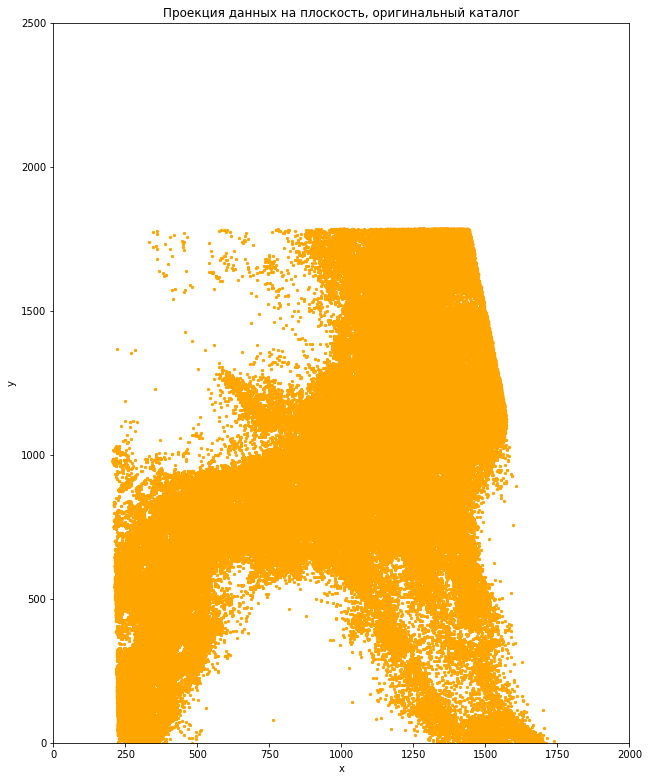

In [20]:
plot_projected_data(data_cat_orig, title='Проекция данных на плоскость, оригинальный каталог')

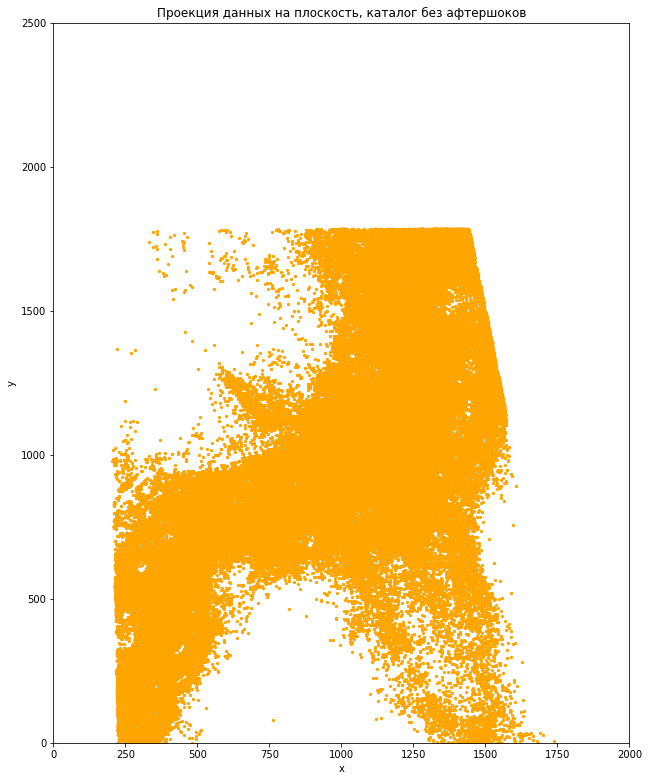

In [26]:
plot_projected_data(data_without_aft_cat, title='Проекция данных на плоскость, каталог без афтершоков')

## Splitting dataset by days and cells

In [59]:
LEFT_BORDER = 0
RIGHT_BORDER = 2000
DOWN_BORDER = 0
UP_BORDER = 2500
N_CELLS_HOR = 200
N_CELLS_VER = 250

# from orinal paper
CELLED_DATA_PATH_CAT_ORIG_SRC = "../data/celled_data_cat_orig"
CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC = "../data/celled_data_without_aft_cat"
# density map
CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY = "../data/celled_data_cat_orig_src_density"
CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY = (
    "../data/celled_data_without_aft_catsrc_density"
)
# max magnitude map
CELLED_DATA_PATH_CAT_ORIG_MAXMAGN = "../data/celled_data_cat_orig_maxmagn"
CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN = "../data/celled_data_without_aft_cat_maxmagn"
# density and max magnitude map
CELLED_DATA_PATH_CAT_ORIG_MAXMAGN_DENSITY = (
    "../data/celled_data_cat_orig_maxmagn_density"
)
CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN_DENSITY = (
    "../data/celled_data_without_aft_cat_maxmagn_density"
)

#### 1. исходное разбиение

In [ ]:
# оригинальный каталог исходное разбиение
celled_data_cat_orig = create_celled_data( 
                                            data = data_cat_orig,
                                            left_border = LEFT_BORDER,
                                            right_border = RIGHT_BORDER,
                                            down_border = DOWN_BORDER,
                                            up_border = UP_BORDER,
                                            n_cells_hor = N_CELLS_HOR,
                                            n_cells_ver = N_CELLS_VER
                                          )

save_celled_data(
                    celled_data=celled_data_cat_orig, 
                    pathname=CELLED_DATA_PATH_CAT_ORIG_SRC, 
                    n_cells_hor=N_CELLS_HOR, 
                    n_cells_ver=N_CELLS_VER
                )

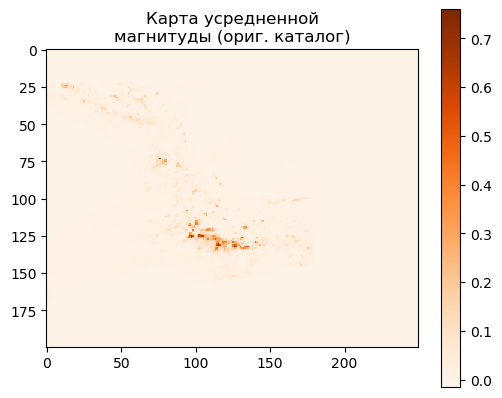

In [153]:
plot_freq_map(celled_data_cat_orig, title_list = ['Карта усредненной\nмагнитуды (ориг. каталог)'])

In [ ]:
# каталог без афтершоков исходное разбиение
celled_data_without_aft_cat = create_celled_data( 
                                            data = data_without_aft_cat,
                                            left_border = LEFT_BORDER,
                                            right_border = RIGHT_BORDER,
                                            down_border = DOWN_BORDER,
                                            up_border = UP_BORDER,
                                            n_cells_hor = N_CELLS_HOR,
                                            n_cells_ver = N_CELLS_VER
                                          )

save_celled_data(
                    celled_data=celled_data_without_aft_cat, 
                    pathname=CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC, 
                    n_cells_hor=N_CELLS_HOR, 
                    n_cells_ver=N_CELLS_VER
                )

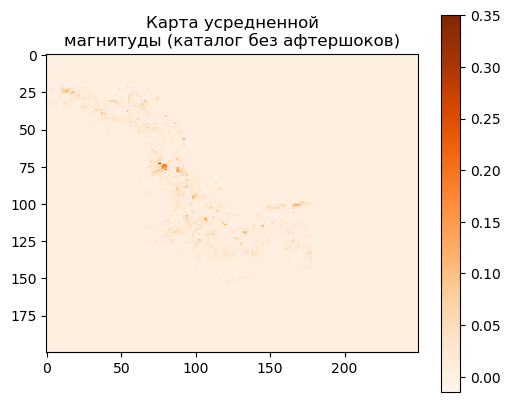

In [154]:
plot_freq_map(celled_data_without_aft_cat, title_list = ['Карта усредненной\nмагнитуды (каталог без афтершоков)'])

#### 2. исходное разбиение с картой плотности

In [ ]:
# оригинальный каталог исходное разбиение с картой плотности
celled_data_cat_orig_density = create_celled_data_density( 
                                            data = data_cat_orig,
                                            left_border = LEFT_BORDER,
                                            right_border = RIGHT_BORDER,
                                            down_border = DOWN_BORDER,
                                            up_border = UP_BORDER,
                                            n_cells_hor = N_CELLS_HOR,
                                            n_cells_ver = N_CELLS_VER
                                          )

save_celled_data(
                    celled_data=celled_data_cat_orig_density, 
                    pathname=CELLED_DATA_PATH_CAT_ORIG_SRC_DENSITY, 
                    n_cells_hor=N_CELLS_HOR, 
                    n_cells_ver=N_CELLS_VER
                )

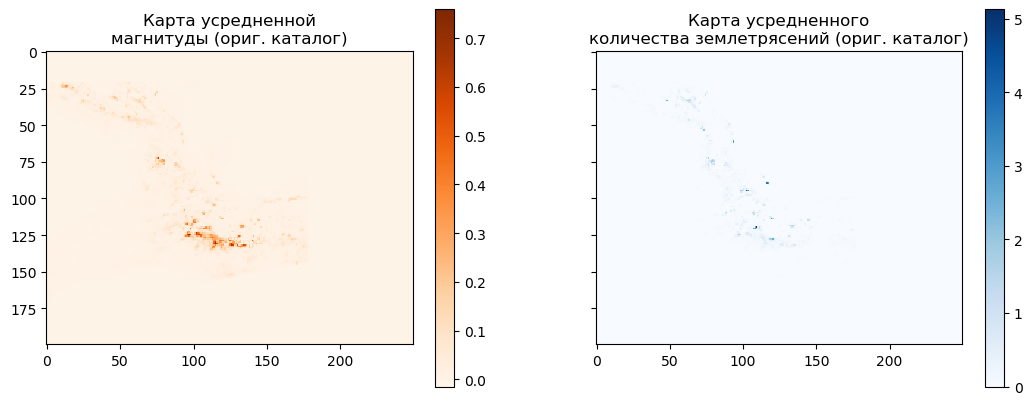

In [136]:
plot_freq_map(celled_data_cat_orig_density, title_list = ['Карта усредненной\nмагнитуды (ориг. каталог)',
                                                         'Карта усредненного\nколичества землетрясений (ориг. каталог)'])

In [ ]:
# каталог без афтершоков исходное разбиение с картой плотности
celled_data_without_aft_cat_density = create_celled_data_density( 
                                            data = data_without_aft_cat,
                                            left_border = LEFT_BORDER,
                                            right_border = RIGHT_BORDER,
                                            down_border = DOWN_BORDER,
                                            up_border = UP_BORDER,
                                            n_cells_hor = N_CELLS_HOR,
                                            n_cells_ver = N_CELLS_VER
                                          )

save_celled_data(
                    celled_data=celled_data_without_aft_cat_density, 
                    pathname=CELLED_DATA_PATH_WITHOUTAFT_CAT_SRC_DENSITY, 
                    n_cells_hor=N_CELLS_HOR, 
                    n_cells_ver=N_CELLS_VER
                )

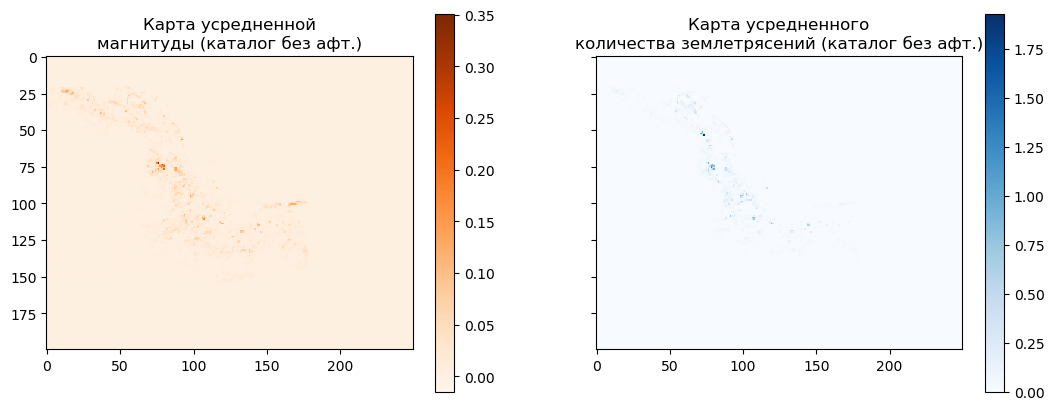

In [135]:
plot_freq_map(celled_data_without_aft_cat_density, title_list = ['Карта усредненной\nмагнитуды (каталог без афт.)',
                                                         'Карта усредненного\nколичества землетрясений (каталог без афт.)'])

#### 3. исходное разбиение, максимальная магнитуда в пикселе

In [146]:
# оригинальный каталог исходное разбиение (максимальная магнитуда в пикселе)
celled_data_cat_orig_max_magn = create_celled_data_max_magn( 
                                            data = data_cat_orig,
                                            left_border = LEFT_BORDER,
                                            right_border = RIGHT_BORDER,
                                            down_border = DOWN_BORDER,
                                            up_border = UP_BORDER,
                                            n_cells_hor = N_CELLS_HOR,
                                            n_cells_ver = N_CELLS_VER
                                          )


save_celled_data(
                    celled_data=celled_data_cat_orig_max_magn, 
                    pathname=CELLED_DATA_PATH_CAT_ORIG_MAXMAGN, 
                    n_cells_hor=N_CELLS_HOR, 
                    n_cells_ver=N_CELLS_VER
                )


torch.Size([7066, 1, 200, 250])


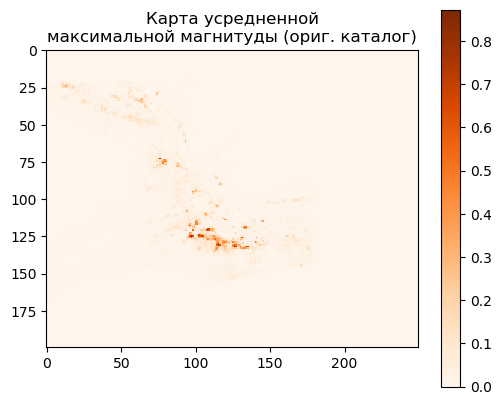

In [155]:
plot_freq_map(celled_data_cat_orig_max_magn, title_list = ['Карта усредненной\nмаксимальной магнитуды (ориг. каталог)'])

In [144]:
# каталог без афтершоков исходное разбиение (максимальная магнитуда в пикселе)
celled_data_without_aft_cat_max_magn = create_celled_data_max_magn( 
                                            data = data_without_aft_cat,
                                            left_border = LEFT_BORDER,
                                            right_border = RIGHT_BORDER,
                                            down_border = DOWN_BORDER,
                                            up_border = UP_BORDER,
                                            n_cells_hor = N_CELLS_HOR,
                                            n_cells_ver = N_CELLS_VER
                                          )

save_celled_data(
                    celled_data=celled_data_without_aft_cat_max_magn, 
                    pathname=CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN, 
                    n_cells_hor=N_CELLS_HOR, 
                    n_cells_ver=N_CELLS_VER
                )


torch.Size([7066, 1, 200, 250])


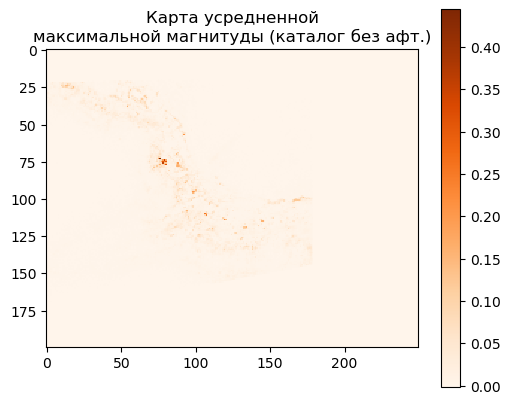

In [156]:
plot_freq_map(celled_data_without_aft_cat_max_magn, 
              title_list = ['Карта усредненной\nмаксимальной магнитуды (каталог без афт.)'])

#### 4. разбиение с картой плотности, максимальная магнитуда в пикселе

In [148]:
# оригинальный каталог разбиение с картой плотности (максимальная магнитуда в пикселе)
celled_data_cat_orig_maxmagn_density = create_celled_data_density_max_magn( 
                                            data = data_cat_orig,
                                            left_border = LEFT_BORDER,
                                            right_border = RIGHT_BORDER,
                                            down_border = DOWN_BORDER,
                                            up_border = UP_BORDER,
                                            n_cells_hor = N_CELLS_HOR,
                                            n_cells_ver = N_CELLS_VER
                                          )


save_celled_data(
                    celled_data=celled_data_cat_orig_maxmagn_density, 
                    pathname=CELLED_DATA_PATH_CAT_ORIG_MAXMAGN_DENSITY, 
                    n_cells_hor=N_CELLS_HOR, 
                    n_cells_ver=N_CELLS_VER
                )


torch.Size([7066, 2, 200, 250])


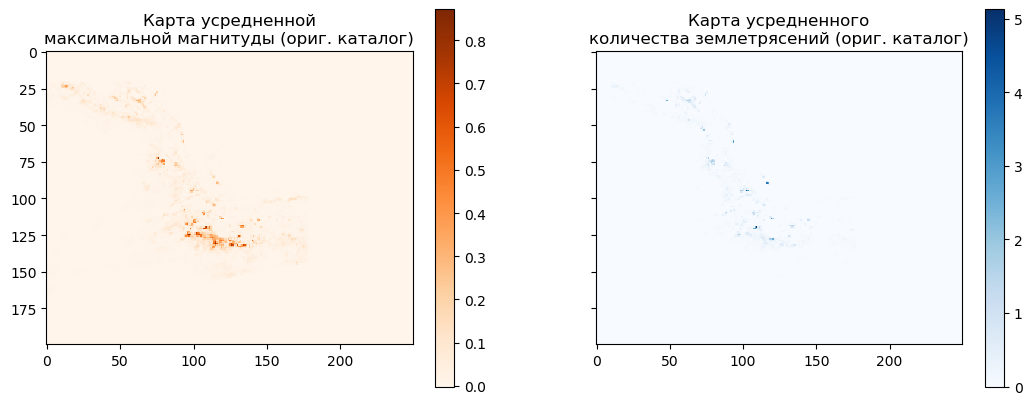

In [149]:
plot_freq_map(celled_data_cat_orig_maxmagn_density, title_list = ['Карта усредненной\nмаксимальной магнитуды (ориг. каталог)',
                                                         'Карта усредненного\nколичества землетрясений (ориг. каталог)'])

In [150]:
# каталог без афтершоков разбиение с картой плотности (максимальная магнитуда в пикселе)
celled_data_without_aft_cat_maxmagn_density = create_celled_data_density_max_magn( 
                                            data = data_without_aft_cat,
                                            left_border = LEFT_BORDER,
                                            right_border = RIGHT_BORDER,
                                            down_border = DOWN_BORDER,
                                            up_border = UP_BORDER,
                                            n_cells_hor = N_CELLS_HOR,
                                            n_cells_ver = N_CELLS_VER
                                          )

save_celled_data(
                    celled_data=celled_data_without_aft_cat_maxmagn_density, 
                    pathname=CELLED_DATA_PATH_WITHOUTAFT_CAT_MAXMAGN_DENSITY, 
                    n_cells_hor=N_CELLS_HOR, 
                    n_cells_ver=N_CELLS_VER
                )


torch.Size([7066, 2, 200, 250])


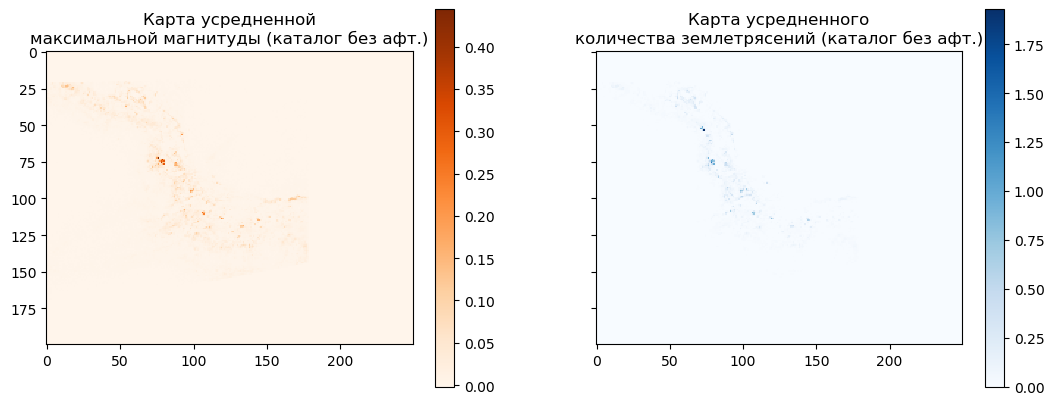

In [151]:
plot_freq_map(celled_data_without_aft_cat_maxmagn_density, 
              title_list = ['Карта усредненной\nмаксимальной магнитуды (каталог без афт.)',
                             'Карта усредненного\nколичества землетрясений (каталог без афт.)'])